# Explaining model predictions with SHAP

## Setup steps

In [1]:
tree_type = 'pairTree'
num_entries = 100000

datapath = '/home/sebastian/analysis/data/HFstudy/workingData/CA_AnalysisResults_Upgrade_HFenh_pairTree-us_part1_0.2nEvents.root'
selection = '((firstMothersInfo1==1 && generator==3) || (firstMothersInfo1==2 && generator==4) || (firstMothersInfo1==2 && generator==5)) && electronsWithHFMother <= 2'

datapath_2 = '/home/sebastian/analysis/data/HFstudy/workingData/CA_AnalysisResults_Upgrade_GP_pairTree-us_part1_0.2nEvents.root'
selection_2 = 'IsRP==1 && IsConv==0'

tag_name = 'class_HF'
tag_val1 = 1
tag_val2 = 0

test_sample_size = 0.5

model_path = '/home/sebastian/analysis/data/HFstudy/workingData/MVA__HF_1__DNN_1__results/output/keras_model_saves/weights_final.hdf5'

modules_path = '/home/sebastian/analysis/code/FT2_AnalysisResults_Upgrade/macros/ML/neuralNets/'

In [2]:
from __future__ import division

import sys
from select import select
import os
from pprint import pprint
from tqdm import tqdm

import matplotlib
matplotlib.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd
import root_numpy

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

import keras
from keras.models import load_model

import shap
from shap import KernelExplainer, DenseData, visualize, initjs, Instance
initjs()

sys.path.append(modules_path)
from modules.load_data import load_data, get_branches, engineer_features
from modules.preprocessing import preprocess
from modules.utils import print_dict, print_class_counts

Using TensorFlow backend.


In [3]:
# fix seed for reproducibility
np.random.seed(7)

## Data import and preparation

In [4]:
branches = get_branches(tree_type)

In [5]:
data_HFenh = load_data(datapath,
                       branches=branches,
                       start=0,
                       stop=num_entries,
                       selection=selection)
data_HFenh[tag_name] = tag_val1

data_GP = load_data(datapath_2,
                   branches=branches,
                   start=0,
                   stop=num_entries,
                   selection=selection_2)


Reading file /home/sebastian/analysis/data/HFstudy/workingData/CA_AnalysisResults_Upgrade_HFenh_pairTree-us_part1_0.2nEvents.root...
Imported data: 31845 rows, 40 columns
Imported data: branches = ['px1', 'py1', 'pz1', 'px2', 'py2', 'pz2', 'phiv', 'mass', 'sumz', 'diffz', 'opang', 'nITS1', 'nITS2', 'nITSshared1', 'nITSshared2', 'nTPC1', 'nTPC2', 'DCAx1', 'DCAy1', 'DCAz1', 'DCAx2', 'DCAy2', 'DCAz2', 'ITSchi21', 'ITSchi22', 'TPCchi21', 'TPCchi22', 'pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2', 'PIDeff1', 'PIDeff2', 'IsRP', 'IsConv', 'generator', 'firstMothersInfo1', 'electronsWithHFMother']
Imported data: selection criteria = ((firstMothersInfo1==1 && generator==3) || (firstMothersInfo1==2 && generator==4) || (firstMothersInfo1==2 && generator==5)) && electronsWithHFMother <= 2

Reading file /home/sebastian/analysis/data/HFstudy/workingData/CA_AnalysisResults_Upgrade_GP_pairTree-us_part1_0.2nEvents.root...
Imported data: 30584 rows, 40 columns
Imported data: branches = ['px1', 'py1', 'pz

In [6]:
data_orig = (pd.concat([data_HFenh, data_GP], ignore_index=True))
data_orig = data_orig.reindex(range(data_orig.shape[0]))

In [7]:
y = pd.DataFrame()
y = (data_orig[tag_name]==tag_val1).astype(int)

In [8]:
X, labels = engineer_features(data_orig, tree_type)
print('Engineered features: {}'.format(labels.tolist()))

Engineered features: ['p', 'phiv', 'mass', 'pz_diff', 'sumz', 'diffz', 'opang', 'nITS1', 'nITS2', 'nITSshared1', 'nITSshared2', 'nTPC1', 'nTPC2', 'DCAx1', 'DCAx2', 'DCAy1', 'DCAy2', 'DCAz1', 'DCAz2', 'ITSchi21', 'ITSchi22', 'TPCchi21', 'TPCchi22', 'pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2']


In [9]:
print('\nSplitting the data in training and test samples...')
    
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_sample_size,
                                                    random_state=42)

print_class_counts(y_train, 'training', background=0, signal=1)
print_class_counts(y_test, 'test', background=0, signal=1)


Splitting the data in training and test samples...

Number of training samples: 31214
  Number of background: 15196 (48.68 percent)
  Number of signal: 16018 (51.32 percent)

Number of test samples: 31215
  Number of background: 15388 (49.30 percent)
  Number of signal: 15827 (50.70 percent)


In [10]:
# Data preprocessing
X_train = preprocess(X_train, tree_type)
X_test = preprocess(X_test, tree_type, load_fitted_attributes=True)

# Convert pandas to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


Data preprocessing: Scaling to zero mean and unit variance
  Fitting new scaling attributes...


/home/sebastian/analysis/code/FT2_AnalysisResults_Upgrade/macros/ML/neuralNets/modules/preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[column] -= mean
/home/sebastian/analysis/code/FT2_AnalysisResults_Upgrade/macros/ML/neuralNets/modules/preprocessing.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[column] /= std
/home/sebastian/analysis/code/FT2_AnalysisResults_Upgrade/macros/ML/neuralNets/modules/preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try


Data preprocessing: Scaling to zero mean and unit variance
  Loading scaling attributes...


/home/sebastian/analysis/code/FT2_AnalysisResults_Upgrade/macros/ML/neuralNets/modules/preprocessing.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[column] -= scaling_attributes[column]['mean']
/home/sebastian/analysis/code/FT2_AnalysisResults_Upgrade/macros/ML/neuralNets/modules/preprocessing.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[column] /= scaling_attributes[column]['std']
/home/sebastian/analysis/code/FT2_AnalysisResults_Upgrade/macros/ML/neuralNets/modules/preprocessing.py:76: SettingWithCopyWarning: 
A value is

## Model import

In [11]:
model = load_model(model_path)

## Explaining model predictions with SHAP

### Explain a single prediction

In [12]:
def f(X):
    return model.predict(X).flatten()

In [13]:
explainer = KernelExplainer(f, X_train[0:1000,:], nsamples=1000)

In [14]:
i = 1
e = explainer.explain(Instance(X_test[i:i+1,:], list(labels)))
visualize(e)

### Explain many predictions

In [15]:
num_explain = 50

In [16]:
explanations = []
for i in tqdm(range(num_explain)):
    explanations.append(explainer.explain(Instance(X_test[i:i+1,:],
                                                   list(labels))))

100%|██████████| 50/50 [1:01:34<00:00, 73.88s/it]


In [17]:
visualize(explanations)

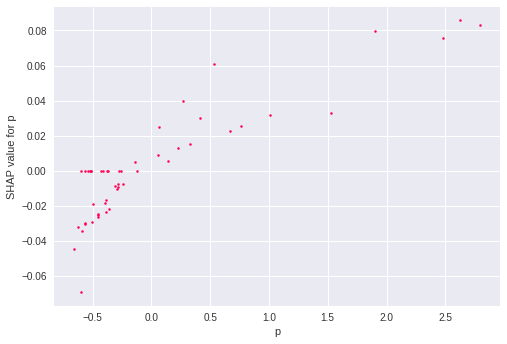

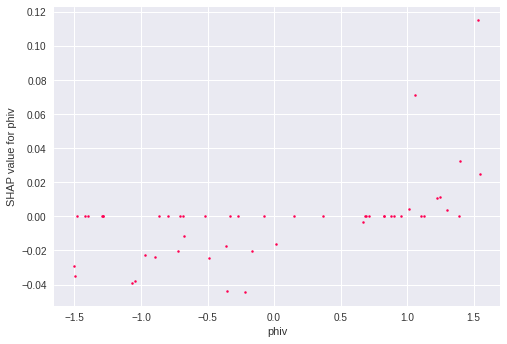

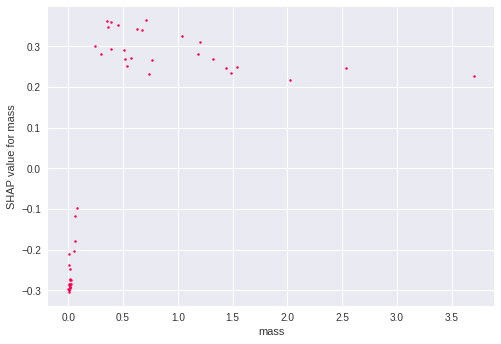

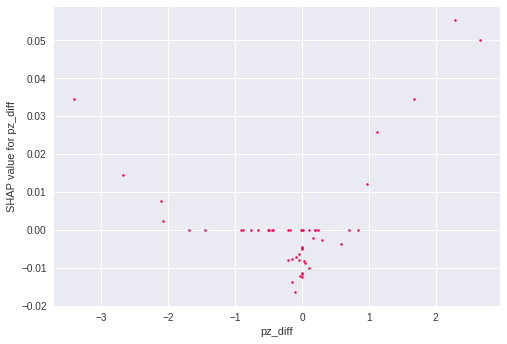

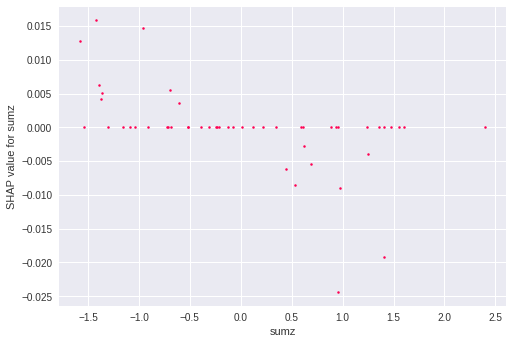

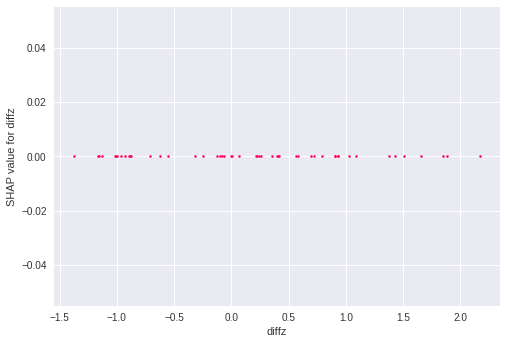

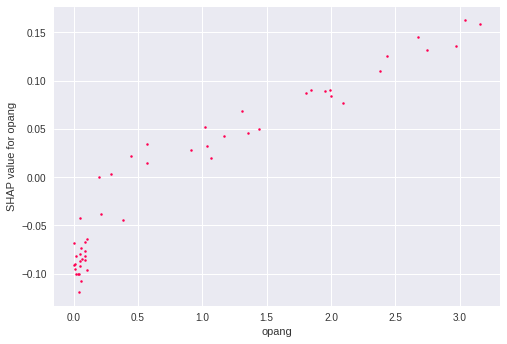

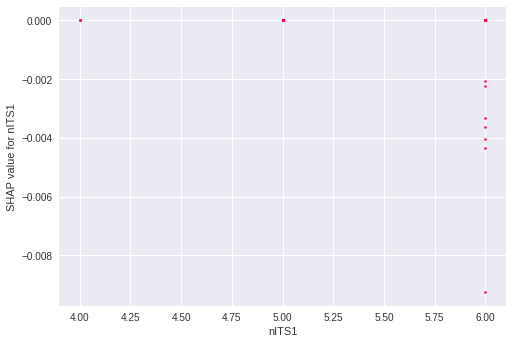

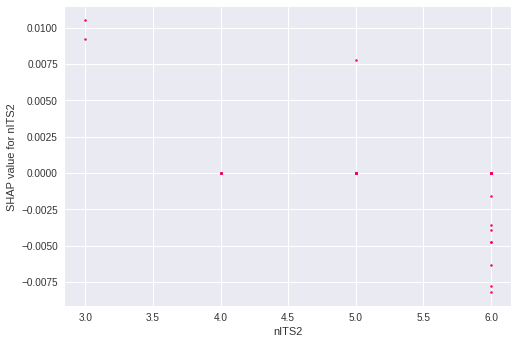

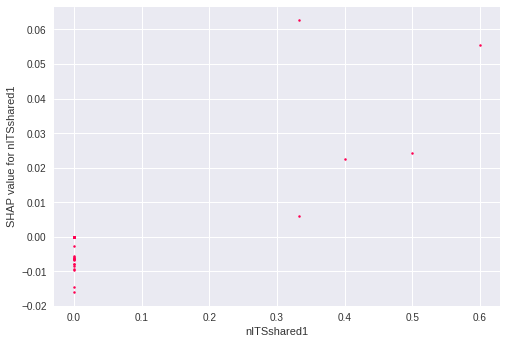

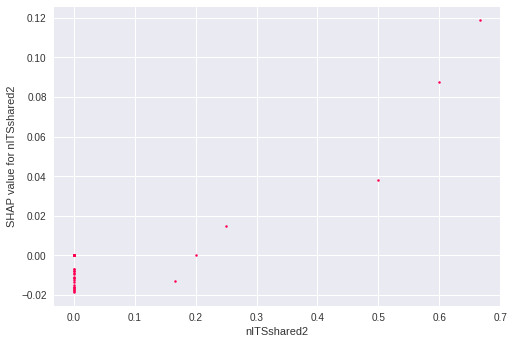

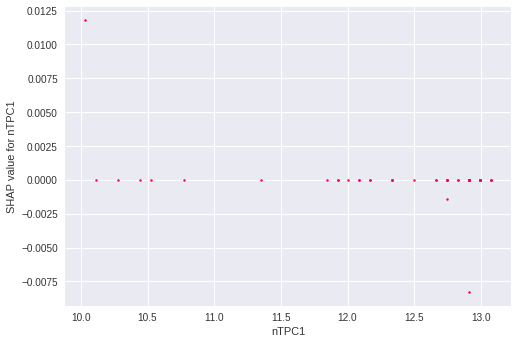

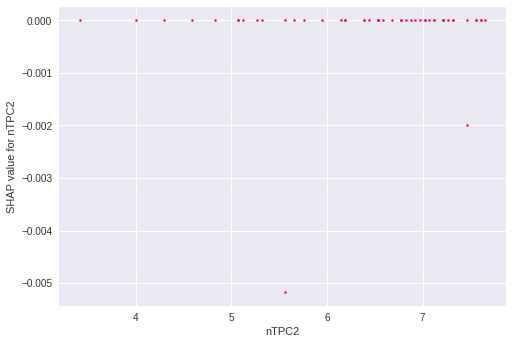

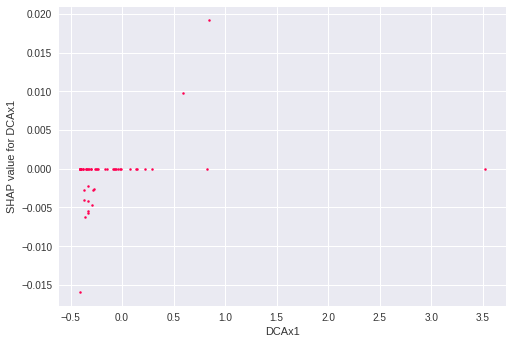

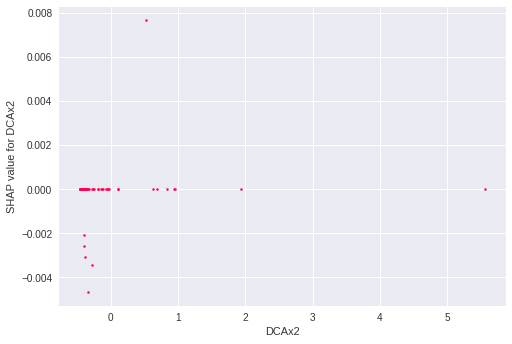

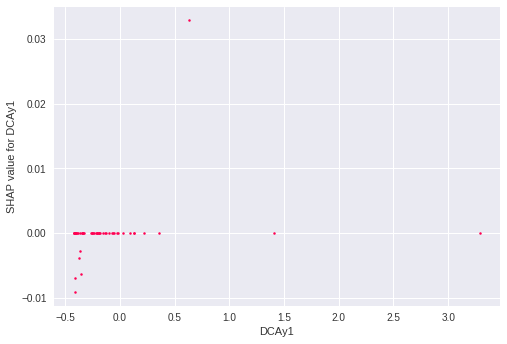

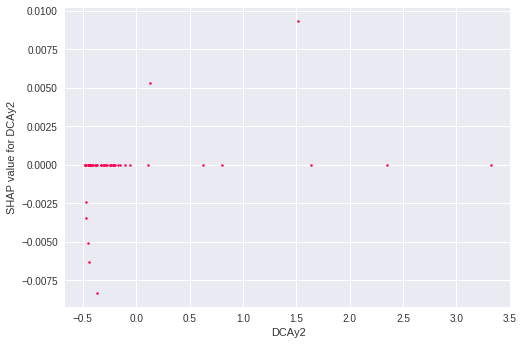

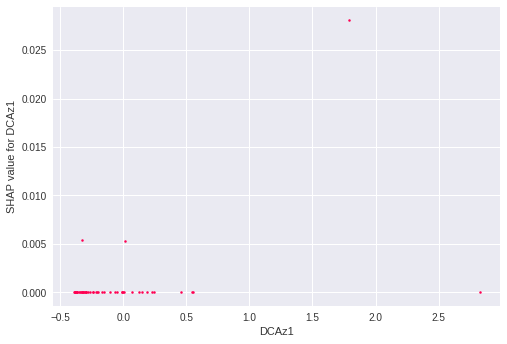

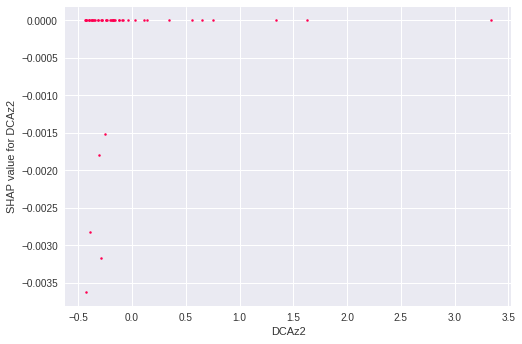

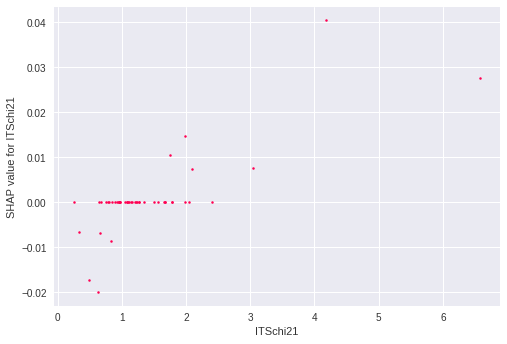

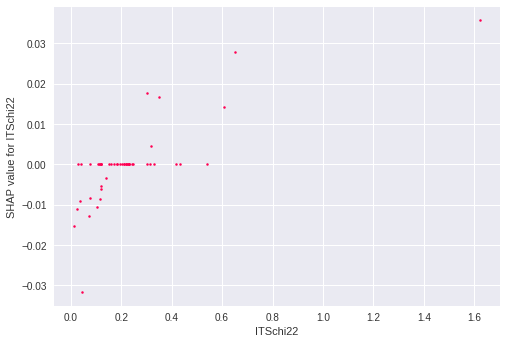

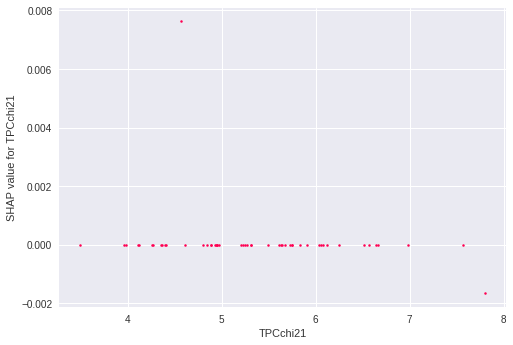

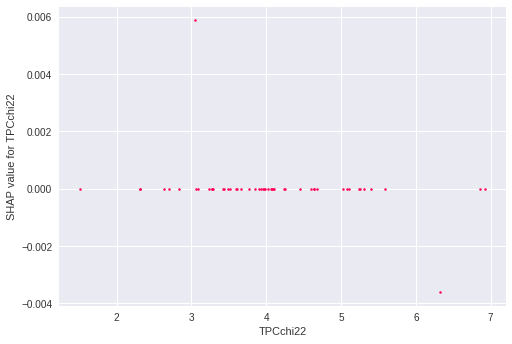

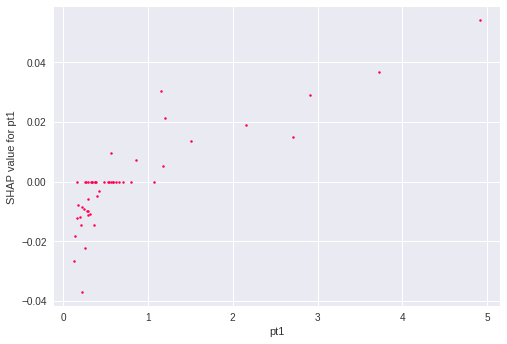

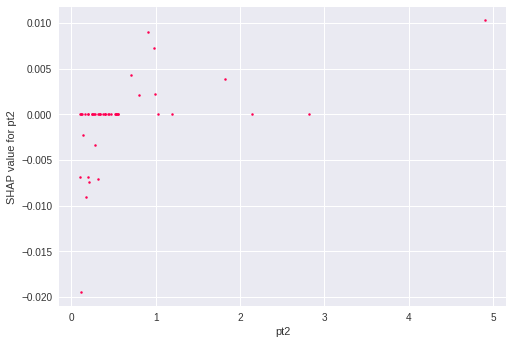

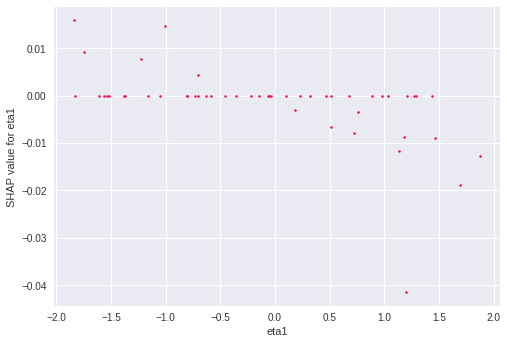

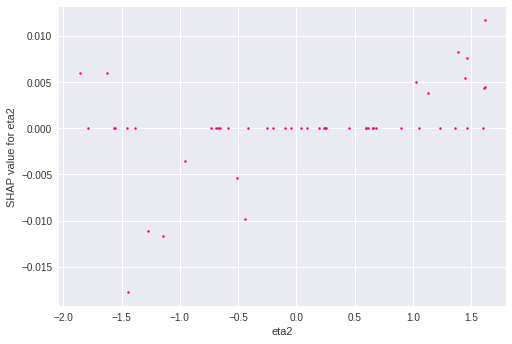

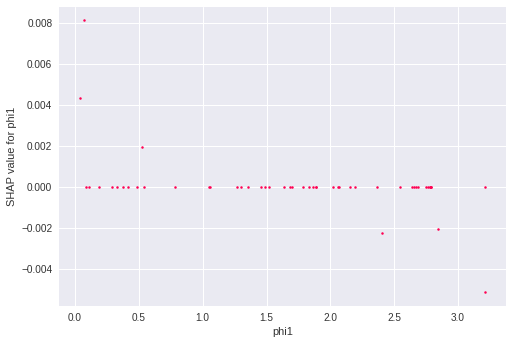

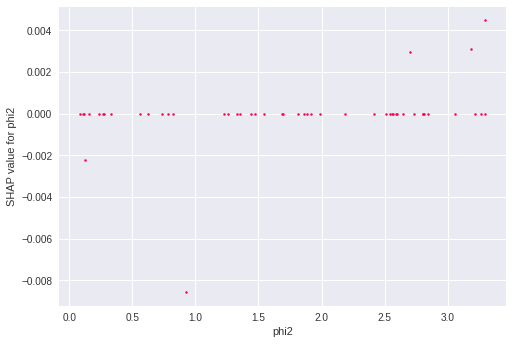

In [22]:
for feat_name in labels.tolist():
    feat = list(labels).index(feat_name)
    shap.plot(X_test[0:num_explain,feat], [e.effects[feat] for e in explanations], feat_name)

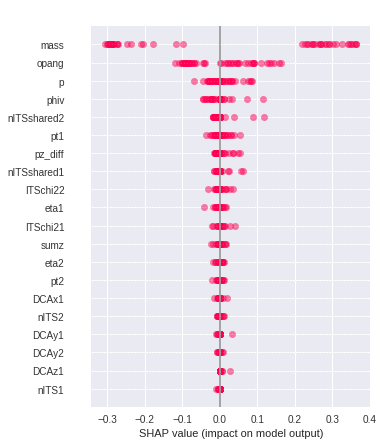

In [19]:
summaryplot = shap.summary_plot(np.vstack([e.effects for e in explanations]),
                  list(labels), violin=False, alpha=0.5)